In [95]:
from functions import map_scatter, glasbey
from matplotlib.ticker import LogLocator, ScalarFormatter, NullFormatter
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy import stats
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
from anndata import AnnData
import pandas as pd
import numpy as np
import seaborn as sns
import colorcet as cc
import scanpy as sc
import copy
import os

In [2]:
# read in dimred_clstr data
data_path = os.path.join('..', 'outputs', 'dimred_clstr.csv')

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    print(f"File not found: {data_path}.\nCheck data path.")

In [3]:
metadata = ['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm', 'Centroid Y µm', 'UMAP1', 'UMAP2', 'PC1', 'PC2', 'Cluster_UMAP']
markers = [col for col in df.columns if col not in metadata]
print(markers)

['DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67', 'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68', 'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14', 'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1', 'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e']


In [4]:
print(len(df[df['Classification'] == 'Other/NA']))
print(len(df[df['Classification'] != 'Other/NA']))

921719
3826900


### Hierarchical Clustering
Based on Figure S1C of [this](https://pubmed.ncbi.nlm.nih.gov/37059105/) paper.

In [5]:
# level 1 classification
def classify_cells(row):
    """ Level 1 classification. """
    s = row['Classification']
    if ('Pan-Cytokeratin' in s) and ('CD45' not in s):
        return 'Epithelial'
    elif ('CD45' in s) and ('Pan-Cytokeratin' not in s):
        return 'Immune'
    else:
        if ('CD45' in s) and ('Pan-Cytokeratin' in s): # not exclusively one or the other
            if row['Pan-Cytokeratin'] > row['CD45']:
                return 'Epithelial'
            else:
                return 'Immune'
        else: # neither
            return 'Other'

# level 2 classification
def classify_level2(row):
    """ Level 2 classification. """
    s = row['Classification']
    lymphoid = ('CD3e' in s) or ('CD20' in s) or ('CD21' in s)
    myeloid = ('CD68' in s) or ('CD11c' in s) or ('CD107a' in s) or ('CD56' in s) or ('Granzyme B' in s)
    if row['Level 1'] == 'Immune':
        if lymphoid and (not myeloid):
            return 'Lymphoid'
        elif (myeloid) and (not lymphoid):
            return 'Myeloid'
        elif lymphoid and myeloid: # not exclusively one or the other
            l = max(row['CD3e'], row['CD20'], row['CD21'])
            m = max(row['CD68'], row['CD11c'], row['CD107a'], row['CD56'], row['Granzyme B'])
            if l > m:
                return 'Lymphoid'
            else:
                return 'Myeloid'
        else:
            return 'Other'
    else:
        return 'Other'

# level 3 classification
def classify_level3(row):
    """ Level 3 classification. """
    s = row['Classification']
    cytotoxic = ('CD3e' in s) and ('CD8' in s)
    helper = ('CD3e' in s) and ('CD4' in s)
    macrophage = 'CD68' in s
    dendritic = 'CD11c' in s
    nk = ('CD107a' in s) and ('CD56' in s) and ('Granzyme B' in s)
    if row['Level 2'] == 'Lymphoid':
        if cytotoxic and (not helper):
            return 'Cyt T'
        elif helper and (not cytotoxic):
            return 'Helper T'
        elif helper and cytotoxic: # not exclusively one or the other
            if row['CD8'] > row['CD4']:
                return 'Cyt T'
            else:
                return 'Helper T'
        else: 
            return 'Other'
    elif row['Level 2'] == 'Myeloid':
        m = row['CD68']
        d = row['CD11c']
        n = max(row['CD107a'], row['CD56'], row['Granzyme B'])
        if macrophage and not (dendritic or nk):
            return 'Macrophage'
        elif dendritic and not (macrophage or nk):
            return 'Dendritic'
        elif nk and not (macrophage or dendritic):
            return 'NK Cell'
        elif macrophage and dendritic:
            if m > d:
                return 'Macrophage'
            else:
                return 'Dendritic'
        elif dendritic and nk:
            if d > n:
                return 'Dendritic'
            else:
                return 'NK Cell'
        elif macrophage and nk:
            if m > n:
                return 'Macrophage'
            else:
                return 'NK Cell'
        else: # none 
            return 'Other'
    else:
        return 'Other'
    
# level 4 classification
def classify_level4(row):
    """ Level 4 classification. """
    s = row['Classification']
    pre = 'TCF-1' in s
    tc = 'PD-1' in s
    ex_tc = ('TOX' in s) and ('CD39' in s)
    e = max(row['TOX'], row['CD39'])
    treg = 'FOXP3' in s
    if row['Level 3'] == 'Cyt T':
        if pre and not (tc or ex_tc):
            return 'Cyt T Precursor'
        elif tc and not (pre or ex_tc):
            return 'Tc'
        elif ex_tc and not (pre or tc):
            return 'Exhausted Tc'
        elif pre and tc:
            if row['TCF-1'] > row['PD-1']:
                return 'Cyt T Precursor'
            else:
                return 'Tc'
        elif pre and ex_tc:
            if row['TCF-1'] > e:
                return 'Cyt T Precursor'
            else:
                return 'Exhausted Tc'
        elif tc and ex_tc:
            if row['PD-1'] > e:
                return 'Tc'
            else:
                return 'Exhausted Tc'
        else:
            return 'Other'
    elif row['Level 3'] == 'Helper T':
        if pre and not treg:
            return 'Helper T Precursor'
        elif treg and not pre:
            return 'T reg'
        elif pre and treg:
            if row['TCF-1'] > row['FOXP3']:
                return 'Helper T Precursor'
            else:
                return 'T reg'
        else:
            return 'Other'
    else:
        return 'Other'

In [6]:
df['Level 1'] = df.apply(classify_cells, axis=1)
df['Level 2'] = df.apply(classify_level2, axis=1)
df['Level 3'] = df.apply(classify_level3, axis=1)
df['Level 4'] = df.apply(classify_level4, axis=1)

In [7]:
metadata.extend(['Level 1', 'Level 2', 'Level 3', 'Level 4'])
print(metadata)

['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm', 'Centroid Y µm', 'UMAP1', 'UMAP2', 'PC1', 'PC2', 'Cluster_UMAP', 'Level 1', 'Level 2', 'Level 3', 'Level 4']


Level 1 clustermap on a random subset

In [8]:
# get the proportion of each group in level 1
for p in df['Level 1'].unique():
    prop = len(df[df['Level 1'] == p]) / len(df.index)
    print(p, prop)
    

Other 0.5528457852693593
Immune 0.445418552214865
Epithelial 0.0017356625157756392


In [9]:
# reduce size by getting mean within lymph nodes within level
df_mean = df[markers + ['Parent', 'Level 1']].groupby(['Parent']).mean(numeric_only=True).reset_index()

In [10]:
df_mean.head()

,Parent,DAPI,CD44,HLA-DR,CD4,IFNG,Ki67,CD107a,CD45,CD20,...,T-bet/TBX21,PD-L1,TOX,PD-1,CD38,ICOS,CD39,LAG3,TCF-1,CD3e
0,Slide 10 C1,0.112654,0.326746,-0.001500,0.133345,-0.037869,-0.075604,0.139179,0.269642,0.279431,...,-0.441919,0.147788,0.288457,-0.090116,0.004528,0.090225,0.113140,0.026987,0.316915,0.255321
1,Slide 10 C1-1,-0.171726,-0.088561,-0.106038,-0.307162,0.008308,-0.001743,-0.068358,-0.213336,-0.171941,...,0.546104,-0.133572,-0.135294,-0.293831,0.111660,-0.282644,-0.027898,-0.290920,-0.218998,-0.294587
2,Slide 10 D1,0.075491,-0.195875,0.108724,0.194600,0.024682,0.067845,-0.052401,-0.019571,-0.070059,...,-0.166938,0.006134,-0.115071,0.376407,-0.117066,0.207451,-0.070627,0.271107,-0.055154,0.075250
3,Slide 11 A1,0.219822,-0.087645,-0.005068,0.202881,-0.031256,0.285999,-0.139885,-0.091552,0.076618,...,-0.231152,0.246357,0.215293,0.313688,-0.101141,0.378709,0.105011,-0.607268,0.230345,0.271279
4,Slide 11 A1-1,0.038314,-0.011515,0.161775,0.042760,0.011698,0.137557,0.238939,0.014951,0.076359,...,0.252214,-0.124502,-0.005044,-0.026457,0.252023,-0.052302,-0.006979,0.260339,0.035833,-0.039328


In [11]:
df_mean.columns

Index(['Parent', 'DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67', 'CD107a',
       'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68', 'HLA-A',
       'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14', 'CD56',
       'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1', 'TOX',
       'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e'],
      dtype='object')

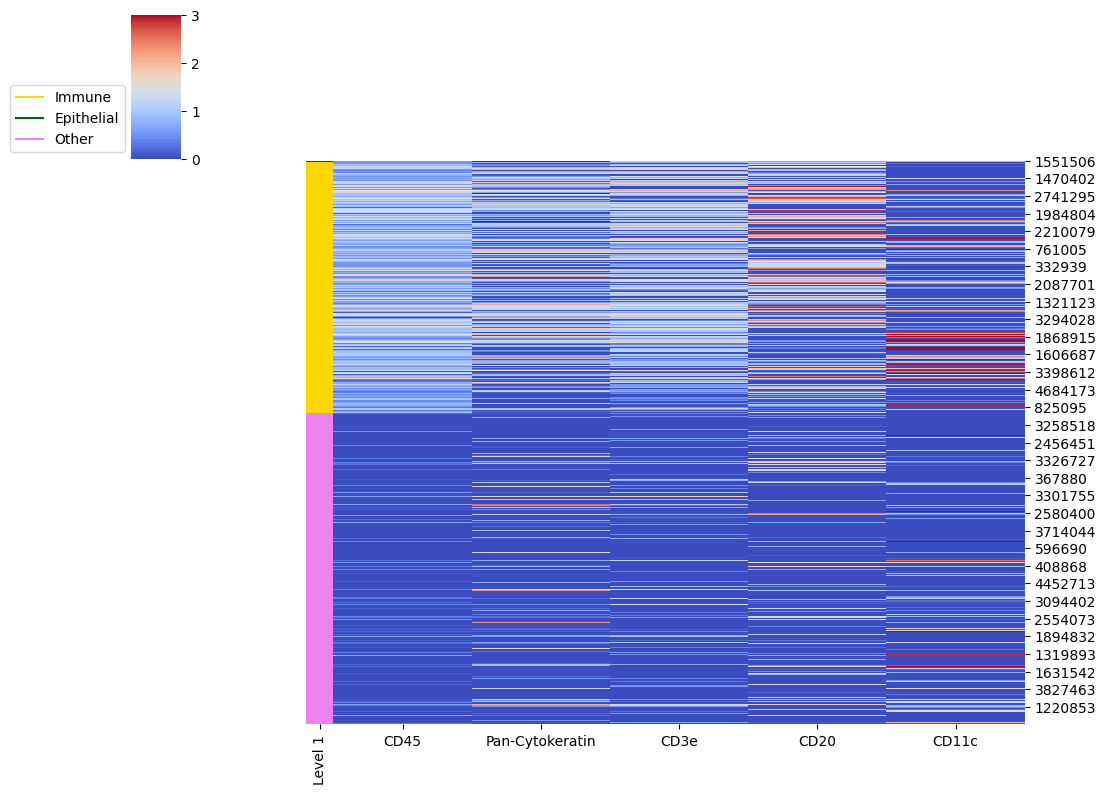

In [89]:
# reduce size by getting sample
lvl1_markers = ['CD45', 'Pan-Cytokeratin', 'CD3e', 'CD20', 'CD11c']
df_ss = df.sample(frac=0.1, random_state=57)

level1_colours = {
    'Immune': 'gold',
    'Epithelial': 'darkgreen',
    'Other': 'violet'
}

df_sorted = df_ss.sort_values(by=['Level 1', 'Level 2'])
row_colours = df_sorted['Level 1'].map(level1_colours) # map each row to a colour based on level
df_biomarkers = df_sorted[lvl1_markers] 

# plot
cg = sns.clustermap(df_biomarkers, row_colors=row_colours, cmap='coolwarm', figsize=(10, 8), vmin=0, vmax=3, row_cluster=False, col_cluster=False)
# cg.ax_heatmap.set_yticks([]) # suppress y-ticks

# legend - figure out separate legends 
for label in level1_colours:
    plt.plot([], [], color=level1_colours[label], label=label)
plt.legend(loc='lower right', bbox_to_anchor=(0, 0))

plt.show()

In [87]:
# reduce size by getting sample
filtered = df_ss[df_ss['Level 1'] == 'Immune'] # get the immune subset
rest_markers = ['CD3e', 'CD8', 'TCF-1', 'PD-1', 'TOX', 'CD39', 'FOXP3', 'CD68', 'CD11c', 'CD107a', 'CD56', 'Granzyme B']

levels = ['Level 2', 'Level 3', 'Level 4']

level2_colours = {
    'Lymphoid': 'gold',
    'Myeloid': 'darkorange',
    'Other': 'white'
}

level3_colours = {
    'Helper T': 'rebeccapurple',
    'Macrophage': 'paleturquoise',
    'Cyt T': 'mediumseagreen',
    'Dendritic': 'hotpink',
    'NK Cell': 'sienna',
    'Other': 'white'
}

level4_colours = {
    'T reg': 'gold',
    'Cyt T Precursor': 'blue',
    'Helper T Precursor': 'greenyellow',
    'Tc': 'red',
    'Exhausted Tc': 'deepskyblue',
    'Other': 'white'
}

df_sorted = df_ss.sort_values(by=levels)
row_lv2_colours = df_sorted['Level 2'].map(level2_colours) # map each row to a colour based on level
row_lv3_colours = df_sorted['Level 3'].map(level3_colours)
row_lv4_colours = df_sorted['Level 4'].map(level4_colours)
df_biomarkers = df_sorted[rest_markers] 
row_colours = pd.concat([row_lv4_colours, row_lv3_colours, row_lv2_colours], axis=1)
row_colours.head()

,Level 4,Level 3,Level 2
655729,blue,mediumseagreen,gold
4213825,blue,mediumseagreen,gold
1486046,blue,mediumseagreen,gold
430163,blue,mediumseagreen,gold
2177128,blue,mediumseagreen,gold


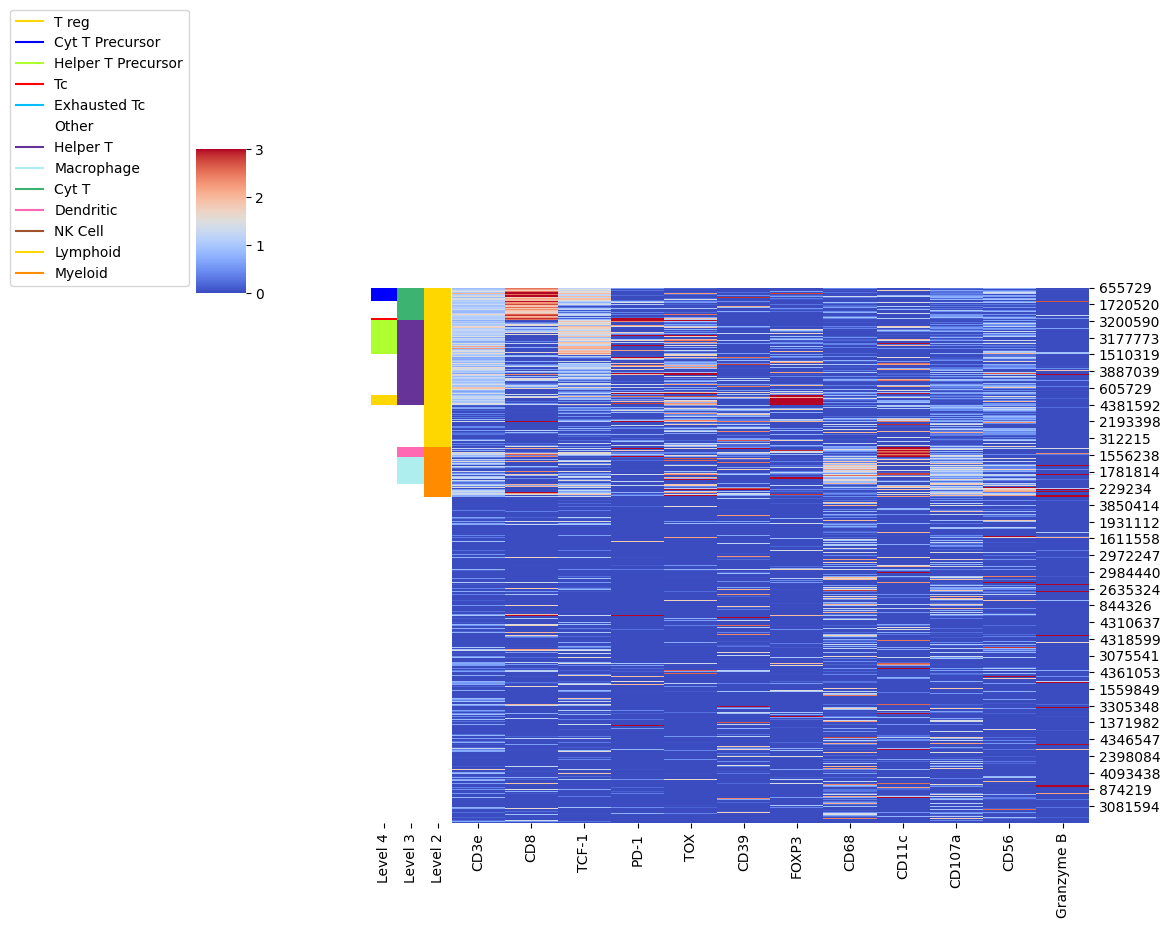

In [88]:
# plot
cm = sns.clustermap(df_biomarkers, row_colors=row_colours, cmap='coolwarm', figsize=(10, 8), vmin=0, vmax=3, row_cluster=False, col_cluster=False)
# cm.ax_heatmap.set_yticks([]) # suppress y-ticks

# legend - figure out separate legends 
colours = level4_colours | level3_colours | level2_colours
for label in colours:
    plt.plot([], [], color=colours[label], label=label)
plt.legend(loc='lower right', bbox_to_anchor=(0, 0))

plt.show()

### Figure 2 plots

In [53]:
def determine_phenotype(row):
  """ Assign the most granular phenotype possible. """
  if row['Level 4'] != 'Other':
    return row['Level 4']
  elif row['Level 3'] != 'Other':
    return row['Level 3']
  elif row['Level 2'] != 'Other':
    return row['Level 2']
  elif row['Level 1'] != 'Other':
    return row['Level 1']
  return 'Other'  # default value if all levels are 'Other'

In [54]:
df['Phenotype'] = df.apply(determine_phenotype, axis=1)
print(df['Phenotype'].unique())

['Other' 'Helper T' 'Macrophage' 'Immune' 'T reg' 'Myeloid'
 'Cyt T Precursor' 'Cyt T' 'Lymphoid' 'Helper T Precursor' 'Dendritic'
 'Tc' 'NK Cell' 'Epithelial' 'Exhausted Tc']


In [ ]:
# make the 'Timepoint' column for ease of comparison
pre_timepoints = ['Slide 11 B1', 'Slide 11 A1', 'Slide 11 A1-1', 'Slide 9 A1', 'Slide 9 B2', 'Slide 9 A1-1']
df['Timepoint'] = df['Parent'].apply(lambda x: 'DLN pre' if x in pre_timepoints else 'DLN post')
print(df.head())

log2 fold change in proportions of each phenotype from pre to post DLN

In [58]:
df.columns

Index(['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm',
       'Centroid Y µm', 'DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67',
       'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68',
       'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14',
       'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1',
       'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e', 'UMAP1',
       'UMAP2', 'PC1', 'PC2', 'Cluster_UMAP', 'Level 1', 'Level 2', 'Level 3',
       'Level 4', 'Phenotype', 'Timepoint'],
      dtype='object')

0.0
0.00035893056036578625
0.0
0.0
6.374541873140897e-76
0.0
3.9019227089599503e-280
0.0
0.0
0.0
0.0
2.596603366572022e-118
0.0
4.38808529174575e-37
3.939179869198121e-76


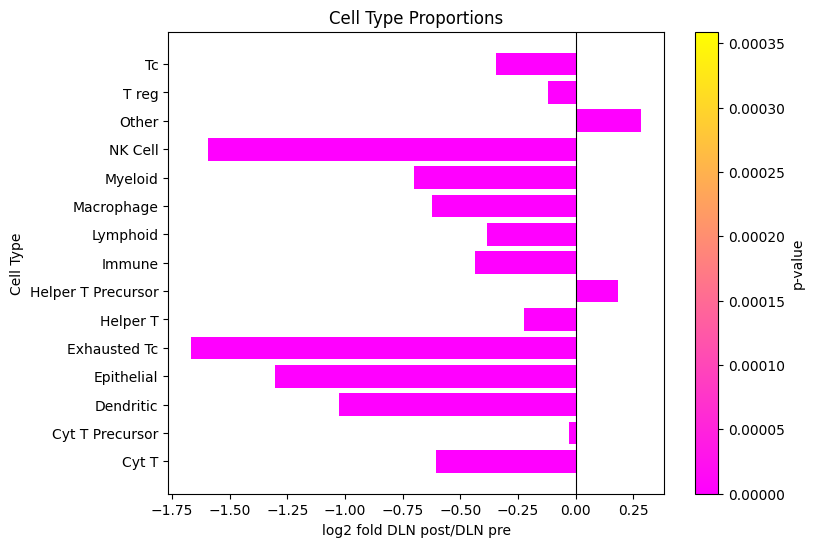

In [93]:
# proportions of each phenotype at each timepoint
prop_df = df.groupby(['Timepoint', 'Phenotype']).size().unstack(fill_value=0)
prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)

log2_fold_change = np.log2(prop_df.loc['DLN post'] / prop_df.loc['DLN pre'])

p_values = []
for phenotype in prop_df.columns:
    prop_t1 = df[df['Timepoint'] == 'DLN pre']['Phenotype'] == phenotype
    prop_t2 = df[df['Timepoint'] == 'DLN post']['Phenotype'] == phenotype
    
    prop_t1 = prop_t1.astype(int)
    prop_t2 = prop_t2.astype(int)
    
    # run independent t-test
    _, p_value = ttest_ind(prop_t1, prop_t2, equal_var=False) 
    print(p_value)
    p_values.append(p_value)

p_values = pd.Series(p_values, index=prop_df.columns)
cmap = mpl.cm.spring # colour map
colours = [cmap(p_val) for p_val in p_values]

# plot horizontal bar
fig, ax = plt.subplots(figsize=(8, 6))
phenotypes = log2_fold_change.index

bars = ax.barh(phenotypes, log2_fold_change, color=colours)
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('log2 fold DLN post/DLN pre')
ax.set_ylabel('Cell Type')
ax.set_title('Cell Type Proportions')

# p-value annotations
# for i, (log2_fc, p_val) in enumerate(zip(log2_fold_change, p_values)):
#     ax.text(log2_fc, i, f'p={p_val:.3e}', va='center', ha='right' if log2_fc < 0 else 'left')

# colour bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=p_values.min(), vmax=p_values.max()))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('p-value')

plt.show()

Plot change in ratio of phenotypes from pre to post DLN

In [64]:
print(df['Phenotype'].unique())

['Other' 'Helper T' 'Macrophage' 'Immune' 'T reg' 'Myeloid'
 'Cyt T Precursor' 'Cyt T' 'Lymphoid' 'Helper T Precursor' 'Dendritic'
 'Tc' 'NK Cell' 'Epithelial' 'Exhausted Tc']


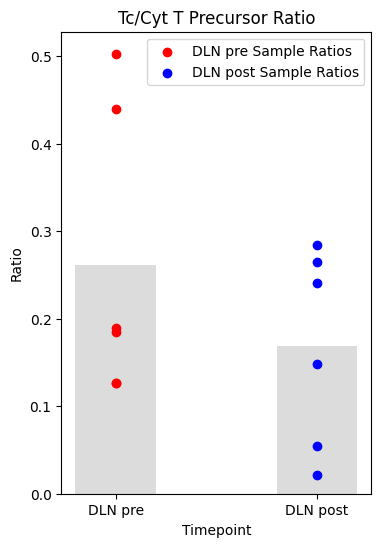

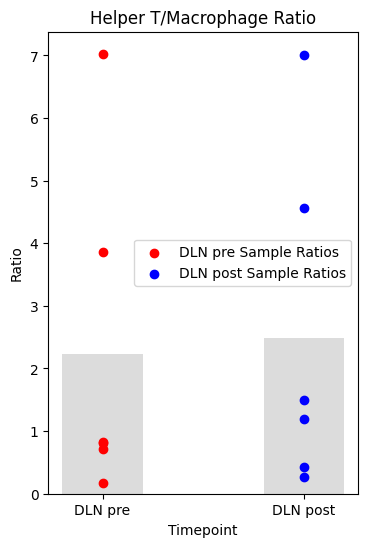

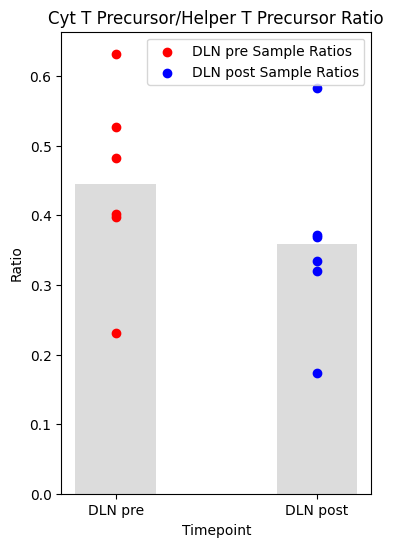

In [69]:
phen_ratios_toplot = [('Tc', 'Cyt T Precursor'), ('Helper T', 'Macrophage'), ('Cyt T Precursor', 'Helper T Precursor')]
for pair in phen_ratios_toplot:

    timepoint_dict = {}
    for timepoint, group in df.groupby('Timepoint'):
        sample_ratios = []
        for sample, sample_group in group.groupby('Parent'):

            phen1 = sample_group['Phenotype'].value_counts().get(pair[0], 0)
            phen2 = sample_group['Phenotype'].value_counts().get(pair[1], 0)
            if phen2 > 0:
                ratio = phen1 / phen2
            else:
                ratio = 0  # denom 0 case
            sample_ratios.append(ratio)

        # bar height = avg ratio for the timepoint
        bar_height = np.mean(sample_ratios) if sample_ratios else 0
        timepoint_dict[timepoint] = (bar_height, sample_ratios)

    # plot
    fig, ax = plt.subplots(figsize=(4, 6))
    
    # define the order of timepoints
    timepoints = ['DLN pre', 'DLN post']
    
    bar_heights = [timepoint_dict.get(tp, (0, []))[0] for tp in timepoints]
    sample_ratios_list = [timepoint_dict.get(tp, ([], []))[1] for tp in timepoints]
    
    bars = ax.bar(timepoints, bar_heights, color='gainsboro', width=0.4)

    colors = {'DLN pre': 'red', 'DLN post': 'blue'}
    # add sample ratios as colored points
    for i, (timepoint, sample_ratios) in enumerate(zip(timepoints, sample_ratios_list)):
        ax.scatter([timepoint] * len(sample_ratios), sample_ratios, color=colors[timepoint], label=f'{timepoint} Sample Ratios', zorder=5)

    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Ratio')
    ax.set_title(f'{pair[0]}/{pair[1]} Ratio')
    ax.legend()
    plt.show()

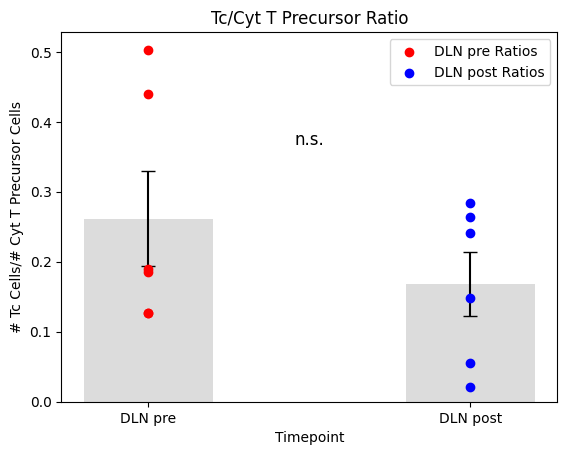

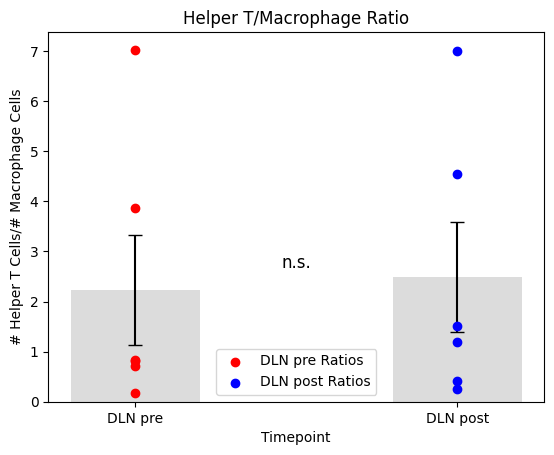

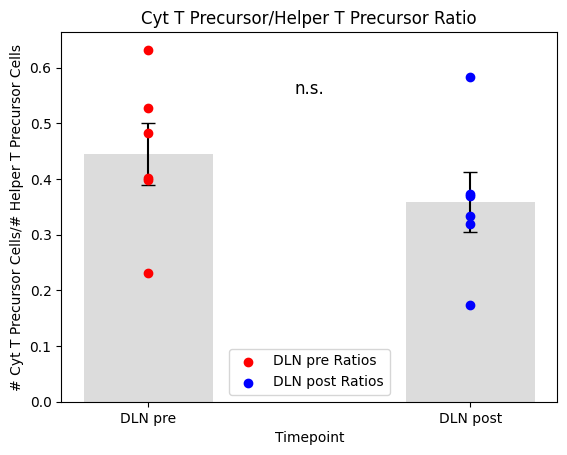

In [72]:
phen_ratios_toplot = [('Tc', 'Cyt T Precursor'), ('Helper T', 'Macrophage'), ('Cyt T Precursor', 'Helper T Precursor')]
for pair in phen_ratios_toplot:
    timepoint_dict = {}
    for timepoint, group in df.groupby('Timepoint'):
        
        sample_ratios = []
        for sample, sample_group in group.groupby('Parent'):
            
            phen1 = sample_group['Phenotype'].value_counts().get(pair[0], 0)
            phen2 = sample_group['Phenotype'].value_counts().get(pair[1], 0)
        
            if phen2 > 0:
                ratio = phen1 / phen2
            else:
                ratio = 0  # denom 0 case
            sample_ratios.append(ratio)

        # get avg ratio and stderr for the timepoint
        if sample_ratios:
            bar_height = np.mean(sample_ratios)
            std_error = np.std(sample_ratios, ddof=1) / np.sqrt(len(sample_ratios))
        else:
            bar_height = 0
            std_error = 0

        timepoint_dict[timepoint] = (bar_height, std_error, sample_ratios)

    # plot
    fig, ax = plt.subplots()

    # define the order of timepoints
    timepoints = ['DLN pre', 'DLN post']
    bar_heights = [timepoint_dict[tp][0] for tp in timepoints]
    std_errors = [timepoint_dict[tp][1] for tp in timepoints]
    sample_ratios_list = [timepoint_dict[tp][2] for tp in timepoints]

    bars = ax.bar(timepoints, bar_heights, yerr=std_errors, color='gainsboro', width=0.4, capsize=5)
    colours = {'DLN pre': 'red', 'DLN post': 'blue'}  # updated colours dictionary

    # add sample ratios as coloured points
    for i, (timepoint, sample_ratios) in enumerate(zip(timepoints, sample_ratios_list)):
        if sample_ratios:  # unnecessary handling: check if there are ratios to plot
            ax.scatter([timepoint] * len(sample_ratios), sample_ratios, color=colours[timepoint], label=f'{timepoint} Ratios', zorder=5)

    # determine whether not sig diff or sig, and display p-value if so
    for i in range(len(timepoints)):
        for j in range(i + 1, len(timepoints)):
            tp1 = timepoints[i]
            tp2 = timepoints[j]

            bar1, err1 = bar_heights[i], std_errors[i]
            bar2, err2 = bar_heights[j], std_errors[j]

            if (bar1 - err1 <= bar2 + err2) and (bar1 + err1 >= bar2 - err2):
                ax.text((i + j) / 2, max(bar_heights) + 0.1, 'n.s.', ha='center', va='bottom', fontsize=12)
            else:
                # two-tailed independent t-test
                _, p_value = ttest_ind(timepoint_dict[tp1][2], timepoint_dict[tp2][2], equal_var=False)
                if p_value < 0.1:
                    ax.text((i + j) / 2, max(bar_heights) + 0.1, f'p = {p_value:.2f}', ha='center', va='bottom', fontsize=12)

    ax.set_xlabel('Timepoint')
    ax.set_ylabel(f'# {pair[0]} Cells/# {pair[1]} Cells')
    ax.set_title(f'{pair[0]}/{pair[1]} Ratio')
    ax.legend()
    plt.show()


log2 fold change of biomarkers of interest from pre to post DLN in select phenotypes of interest

In [90]:
print(df['Phenotype'].unique())

['Other' 'Helper T' 'Macrophage' 'Immune' 'T reg' 'Myeloid'
 'Cyt T Precursor' 'Cyt T' 'Lymphoid' 'Helper T Precursor' 'Dendritic'
 'Tc' 'NK Cell' 'Epithelial' 'Exhausted Tc']


/home/nduarte/justin-mayoclinic/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


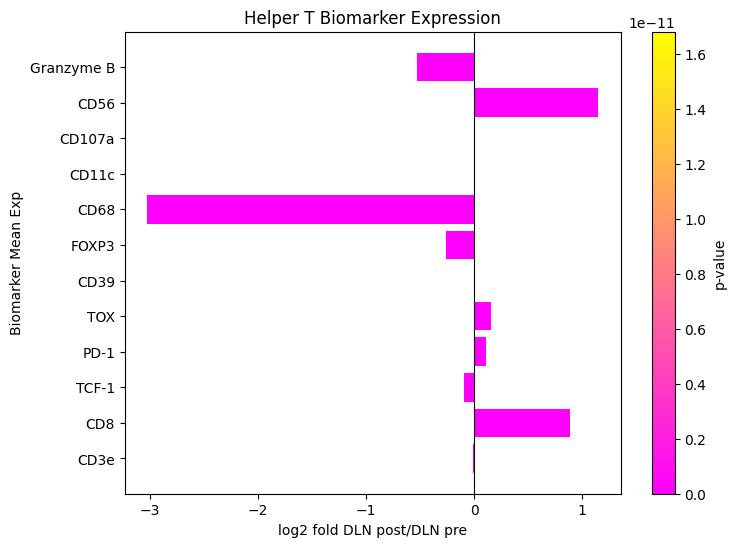

/home/nduarte/justin-mayoclinic/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


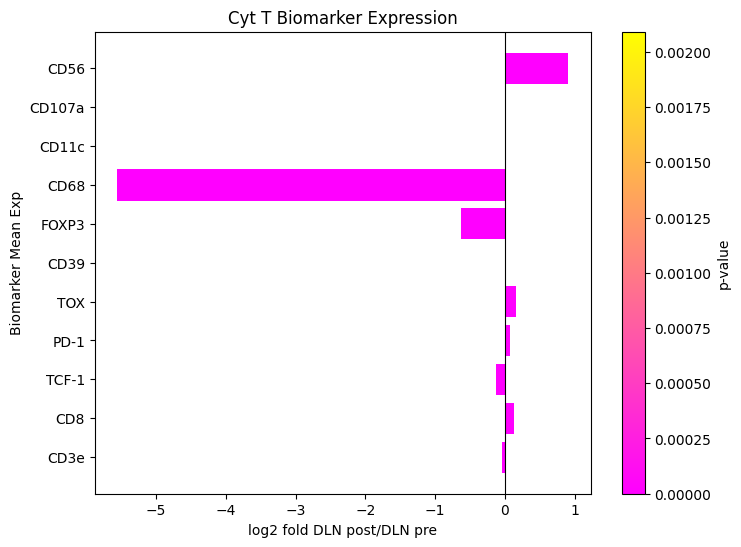

In [94]:
phenotypes_of_interest = ['Helper T', 'Cyt T']
markers_oi = ['CD3e', 'CD8', 'TCF-1', 'PD-1', 'TOX', 'CD39', 'FOXP3', 'CD68', 'CD11c', 'CD107a', 'CD56', 'Granzyme B']

for phenotype in phenotypes_of_interest:
    # get phenotype of interest
    filtered_df = df[df['Phenotype'] == phenotype]
    mean_intensities = filtered_df.groupby('Timepoint')[markers_oi].mean()
    log2_fold_change = np.log2(mean_intensities.loc['DLN post'] / mean_intensities.loc['DLN pre'])

    # independent t-test to get p-values
    p_values = []
    for marker in markers_oi:
        values_t1 = filtered_df[filtered_df['Timepoint'] == 'DLN post'][marker]
        values_t2 = filtered_df[filtered_df['Timepoint'] == 'DLN pre'][marker]
        
        _, p_value = ttest_ind(values_t1, values_t2, equal_var=False)
        p_values.append(p_value)

    p_values = pd.Series(p_values, index=markers_oi)
    cmap = mpl.cm.spring # colour map
    colours = [cmap(p_val) for p_val in p_values]

    # horizontal bar plot
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.barh(log2_fold_change.index, log2_fold_change, color=colours)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_xlabel('log2 fold DLN post/DLN pre')
    ax.set_ylabel('Biomarker Mean Exp')
    ax.set_title(f'{phenotype} Biomarker Expression')

    # colour bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=p_values.min(), vmax=p_values.max()))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('p-value')

    plt.show()


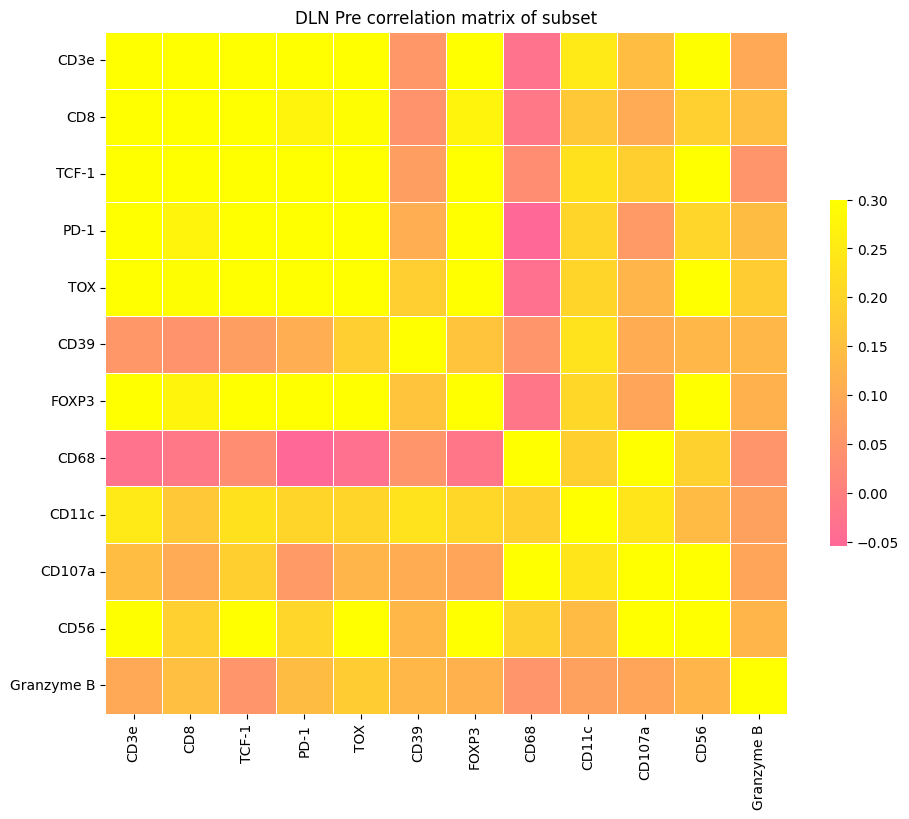

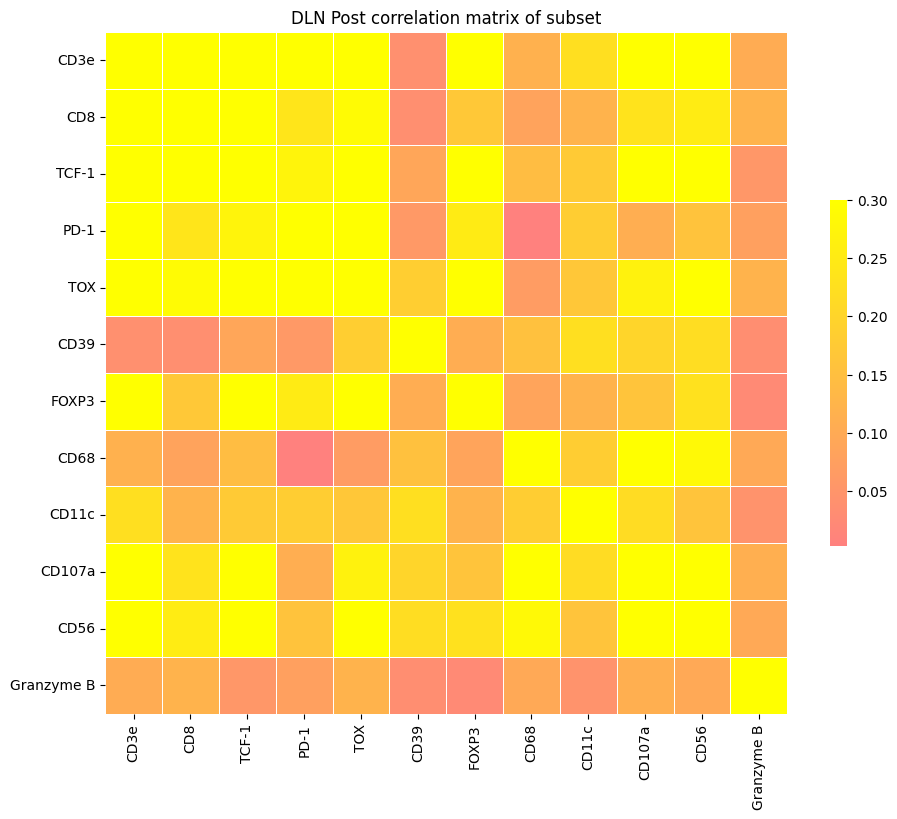

In [106]:
preparents = ['Slide 11 B1', 'Slide 11 A1', 'Slide 11 A1-1', 'Slide 9 A1', 'Slide 9 B2', 'Slide 9 A1-1']
pre = df_ss[df_ss['Parent'].isin(preparents)]
post = df_ss[~df_ss['Parent'].isin(preparents)]

for tp in [('DLN Pre', pre), ('DLN Post', post)]:
    title, frame = tp
    corr = frame[markers_oi].corr()  # compute correlation matrix

    # mask for the upper triangle
    # mask = np.triu(np.ones_like(corr, dtype=bool))

    # plot 
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, 
                # mask=mask, 
                cmap=mpl.cm.spring, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    ax.set_title(f'{title} correlation matrix of subset')
